<h4 style="font-variant-caps: small-caps;font-size:35pt;">Databricks-ML-professional-S01c-Advanced-Experiment-Tracking</h4>

<div style='background-color:black;border-radius:5px;border-top:1px solid'></div>
<br/>
<p>This Notebook adds information related to the following requirements:</p><br/>
<b>Advanced Experiment Tracking:</b>
<ul>
<li>Perform MLflow experiment tracking workflows using model signatures and input examples</li>
<li>Identify the requirements for tracking nested runs</li>
<li>Describe the process of enabling autologging, including with the use of Hyperopt</li>
<li>Log and view artifacts like SHAP plots, custom visualizations, feature data, images, and metadata</li>
</ul>
<br/>
<p><b>Download this notebook at format ipynb <a href="Databricks-ML-professional-S01c-Advanced-Experiment-Tracking.ipynb">here</a>.</b></p>
<br/>
<div style='background-color:black;border-radius:5px;border-top:1px solid'></div>

<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">1. Import libraries</span></div>

In [ ]:
import pandas as pd
import seaborn as sns
#
from pyspark.sql.functions import *
#
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression, FMRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
#
import mlflow
#
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
#
import logging

In [ ]:
logging.getLogger("mlflow").setLevel(logging.FATAL)

<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">2. Load dataset, convert to Spark DataFrame</span></div>

In [ ]:
tips_df = sns.load_dataset("tips")
#
tips_sdf = spark.createDataFrame(tips_df)
#
display(tips_sdf.limit(5))

total_bill,tip,sex,smoker,day,time,size
16.99,1.01,Female,No,Sun,Dinner,2
10.34,1.66,Male,No,Sun,Dinner,3
21.01,3.5,Male,No,Sun,Dinner,3
23.68,3.31,Male,No,Sun,Dinner,2
24.59,3.61,Female,No,Sun,Dinner,4


<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">3. Prepare data</span></div>

<p>Some transformations are done to prepare dataset to be used to train a ML model.</p>
<table border style='border-collapse: collapse;'>
<tr style="background-color:#EDEDED">
    <th>column name</th>
    <th>comment</th>
</tr>
<tr>
    <td><code>tip</code></td>
    <td><b style='color:orangered'>target</b> to predict. Contains numeric</td>
</tr>
<tr>
    <td><code>total_bill</code></td>
    <td>numeric column to keep as is</td>
</tr>
<tr>
    <td><code>sex</code></td>
    <td>Contains <code>Female</code> and <code>Male</code> converted to <code>0</code> and <code>1</code></td>
</tr>
<tr>
    <td><code>smoker</code></td>
    <td>Contains <code>yes</code> and <code>no</code> converted to <code>0</code> and <code>1</code></td>
</tr>
<tr>
    <td><code>time</code></td>
    <td>Contains <code>Dinner</code> and <code>Lunch</code> converted to <code>0</code> and <code>1</code></td>
</tr>
<tr>
    <td><code>day</code></td>
    <td>categorical column to <b>One Hot Encode</b></td>
</tr>
<tr>
    <td><code>size</code></td>
    <td>categorical column to <b>One Hot Encode</b></td>
</tr>
</table>

In [ ]:
tips_sdf = tips_sdf.selectExpr("total_bill",
                               "tip",
                               "case when sex = 'Female' then 1 else 0 end as sex",
                               "case when smoker = 'yes' then 1 else 0 end as smoker",
                               "case when time = 'Dinner' then 1 else 0 end as time",
                               "day",
                               "size")
#
train_df, test_df = tips_sdf.randomSplit([.8, .2], seed=42)
#
ohe_cols = ["size", "day"]
num_cols = ["total_bill", "sex", "smoker", "time"]
target_col = "tip"
#
string_indexer = StringIndexer(inputCols=ohe_cols, outputCols=[c+"_index" for c in ohe_cols], handleInvalid="skip")
#
ohe = OneHotEncoder()
ohe.setInputCols([c+"_index" for c in ohe_cols])
ohe.setOutputCols([c+"_ohe" for c in ohe_cols])
#
assembler_inputs = [c+"_ohe" for c in ohe_cols] + num_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">4. Evaluator and model</span></div>

In [ ]:
glr =       GeneralizedLinearRegression(featuresCol="features", labelCol=target_col, maxIter=10)
lrm =       LinearRegression(featuresCol="features", labelCol=target_col)
fmr =       FMRegressor(featuresCol="features", labelCol=target_col, stepSize=0.001)
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

<a id="signatureandinputexample"></a>
<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">5. Perform MLflow experiment tracking workflows using model signatures and input examples</span></div>

In [ ]:
signature = mlflow.models.infer_signature(train_df, train_df[["tip"]]);
print(signature)

inputs: 
  ['total_bill': double, 'tip': double, 'sex': integer, 'smoker': integer, 'time': integer, 'day': string, 'size': long]
outputs: 
  ['tip': double]



In [ ]:
input_example = train_df.toPandas().head()
input_example

,total_bill,tip,sex,smoker,time,day,size
0,8.77,2.00,0,0,1,Sun,2
1,9.55,1.45,0,0,1,Sat,2
2,9.94,1.56,0,0,1,Sun,2
3,10.27,1.71,0,0,1,Sun,2
4,10.29,2.60,1,0,1,Sun,2


In [ ]:
model_name = "linear-regression"
#
with mlflow.start_run(run_name="Tip-run") as run:
    #
    # define pipeline stages according to model
    stages = [string_indexer, ohe, vec_assembler, lrm]
    #
    # set pipeline
    pipeline = Pipeline(stages=stages)
    #
    # fit pipeline to train set
    model = pipeline.fit(train_df)
    #
    # manually log model to mlflow
    mlflow.spark.log_model(model, model_name, signature=signature, input_example=input_example)
    #
    # manually log parameter to mlflow
    mlflow.log_param("maxIter", 11)
    #
    # predict test set
    pred_df = model.transform(test_df)
    #
    # evaluate prediction
    rmse = evaluator.evaluate(pred_df)
    #
    # manually log metric to mlflow
    mlflow.log_metric("rmse", rmse)

<a id="nestedrun"></a>
<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">6. Identify the requirements for tracking nested runs</span></div>

<p>It is possible to log to mlflow using nested runs:</p>
<a id="nestedrun"></a>

In [ ]:
with mlflow.start_run(run_name="tips_evaluation") as run_parent:
    #
    # loop on the three regression models
    for regression_model in [glr, lrm, fmr]:
        #
        # get model name
        model_name = regression_model.__str__().split("_")[0]
        #
        # Nest mlflow logging
        with mlflow.start_run(run_name=model_name, nested=True) as run:
            #
            # define pipeline stages according to model
            stages = [string_indexer, ohe, vec_assembler, regression_model]
            #
            # set pipeline
            pipeline = Pipeline(stages=stages)
            #
            # fit pipeline to train set
            model = pipeline.fit(train_df)
            #
            # log model to mlflow
            mlflow.spark.log_model(model, model_name, signature=signature, input_example=input_example)
            #
            # predict test set
            pred_df = model.transform(test_df)
            #
            # evaluate prediction
            rmse = evaluator.evaluate(pred_df)
            #
            # log evaluation to mlflow
            mlflow.log_metric("rmse", rmse)

<img src="https://i.ibb.co/TrSPRZP/mlflow6.png"/>

<a id="autologhyperopt"></a>
<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">7. Describe the process of enabling autologging, including with the use of Hyperopt</span></div>

<h5>Here we enable mlflow logging with <code>autolog()</code> and train a simple model. This will automatically log everything possible for each library used.</h5>

In [ ]:
mlflow.autolog()

<p>Now let's fit and evaluate a model:</p>

In [ ]:
# fit pipeline to train set
model_lrm_autolog = pipeline.fit(train_df)
#
# predict test set
pred_df = model_lrm_autolog.transform(test_df)
#
# evaluate
evaluator.evaluate(pred_df)

Out[12]: 1.3054572176798678

<p>After that, in MLflow UI, we can see the many parameters that have been logged.</p>
<p>Alternatively, we can get and see the logged parameters for latest run programmaticaly:</p>

In [ ]:
output_mlflow = (spark.createDataFrame(mlflow.search_runs())
                      .drop(*['tags.mlflow.source.name',
                              'tags.mlflow.databricks.notebookPath',
                              'tags.mlflow.user',
                              'tags.mlflow.databricks.workspaceURL',
                              'tags.mlflow.databricks.cluster.info']))
display(output_mlflow.orderBy(desc("end_time")).limit(1))

run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_test_df,metrics.rmse,metrics.rmse_unknown_dataset,params.FMRegressor.fitIntercept,params.FMRegressor.maxIter,params.OneHotEncoder.outputCol,params.OneHotEncoder.outputCols,params.stages,params.StringIndexer.stringOrderType,params.StringIndexer.inputCols,params.FMRegressor.tol,params.StringIndexer.outputCols,params.StringIndexer.handleInvalid,params.FMRegressor.solver,params.FMRegressor.factorSize,params.OneHotEncoder.handleInvalid,params.OneHotEncoder.inputCols,params.StringIndexer.outputCol,params.FMRegressor.fitLinear,params.FMRegressor.miniBatchFraction,params.VectorAssembler.handleInvalid,params.VectorAssembler.inputCols,params.FMRegressor.predictionCol,params.FMRegressor.regParam,params.FMRegressor.labelCol,params.FMRegressor.featuresCol,params.FMRegressor.initStd,params.FMRegressor.stepSize,params.OneHotEncoder.dropLast,params.FMRegressor.seed,params.VectorAssembler.outputCol,params.maxIter,params.LinearRegression.maxIter,params.LinearRegression.standardization,params.LinearRegression.tol,params.LinearRegression.solver,params.LinearRegression.elasticNetParam,params.LinearRegression.maxBlockSizeInMB,params.LinearRegression.featuresCol,params.LinearRegression.labelCol,params.LinearRegression.fitIntercept,params.LinearRegression.aggregationDepth,params.LinearRegression.loss,params.LinearRegression.predictionCol,params.LinearRegression.epsilon,params.LinearRegression.regParam,tags.mlflow.databricks.cluster.id,tags.mlflow.databricks.cluster.libraries.error,tags.mlflow.databricks.notebookRevisionID,tags.mlflow.databricks.workspaceID,tags.mlflow.databricks.notebook.commandID,tags.mlflow.source.type,tags.mlflow.databricks.webappURL,tags.mlflow.runName,tags.estimator_class,tags.mlflow.autologging,tags.mlflow.databricks.notebookID,tags.estimator_name,tags.mlflow.parentRunId,tags.mlflow.rootRunId,tags.mlflow.log-model.history
08b972964438470595f2ba9ba6aa9d40,3541968995997190,FINISHED,dbfs:/databricks/mlflow-tracking/3541968995997190/08b972964438470595f2ba9ba6aa9d40/artifacts,2023-11-22T16:55:45.974+0000,2023-11-22T16:55:56.280+0000,1.3054572176798678,null,null,True,100,OneHotEncoder_c95dbc53b9cc__output,"['size_ohe', 'day_ohe']","['StringIndexer', 'OneHotEncoder', 'VectorAssembler', 'FMRegressor']",frequencyDesc,"['size', 'day']",1e-06,"['size_index', 'day_index']",skip,adamW,8,error,"['size_index', 'day_index']",StringIndexer_c3caebc64717__output,True,1.0,error,"['size_ohe', 'day_ohe', 'total_bill', 'sex', 'smoker', 'time']",prediction,0.0,tip,features,0.01,0.001,True,-2921654334123211668,features,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1027-081006-5cgi5kuh,This message class grpc_shaded.com.databricks.api.proto.managedLibraries.ClusterStatus DID NOT match any methods in the stub class grpc_shaded.com.databricks.api.proto.cluster.ClusterServiceGrpc$ClusterServiceBlockingStub,1700672156611,3607579860940718,7308506017976005609_4719503818729863905_49d8e6f9a405484da1266fc91cafd976,NOTEBOOK,https://eastus-c3.azuredatabricks.net,colorful-snake-723,pyspark.ml.pipeline.Pipeline,pyspark.ml,3541968995997190,Pipeline,null,null,null


<h5>Let's here use <b>HyperOpt</b> for hyperparameter tuning and use <code>autolog()</code> to log everything.</h5>
<p><b>HyperOpt</b>:</p>
<ul>
<li>Let's first define a function to train each model and log information as nested run of hyperopt analysis in mlflow</li>
<li>After that, definition of the objective function to minimize</li>
</ul>

In [ ]:
def train_model(maxIter, regParam, elasticNetParam, labelCol):
    """
    This train() function:
     - takes hyperparameters as inputs (for tuning later)
     - returns the rmse score on the test dataset
    """
    # Use MLflow to track training.
    # Specify "nested=True" since this single model will be logged as a child run of Hyperopt's run.
    with mlflow.start_run(nested=True):
        #
        model_hyperopt = LinearRegression(maxIter=maxIter,
                                          regParam=regParam,
                                          elasticNetParam=elasticNetParam,
                                          labelCol=target_col)
        #
        evaluator_hyperopt = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
        #
        stages = [string_indexer, ohe, vec_assembler, model_hyperopt]
        #
        # set pipeline
        pipeline = Pipeline(stages=stages)
        #
        # fit pipeline to train set
        model_rfr_hyperopt = pipeline.fit(train_df)
        #
        # predict test set
        pred_df = model_rfr_hyperopt.transform(test_df)
        #
        # evaluate
        rmse = evaluator_hyperopt.evaluate(pred_df)
        #
        # log rmse for each child run
        mlflow.log_metric("rmse", rmse)
    #
    return model_rfr_hyperopt, rmse

In [ ]:
def objective(params):
    """ This function is the function to minimize by hyperopt """
    #
    model, rmse = train_model(maxIter=params["maxIter"],
                              regParam=params["regParam"],
                              elasticNetParam=params["elasticNetParam"],
                              labelCol=target_col)
    #
    return {'loss': rmse, 'status': STATUS_OK}

<p>Let's define the hyperparameter search spaces:</p>

In [ ]:
search_spaces = {"maxIter": hp.quniform("maxIter", 1, 100, 1),
                 "regParam": hp.uniform("regParam", 0.1, 10),
                 "elasticNetParam": hp.uniform("elasticNetParam", 0, 1)}

<p>Finally let's run the hyperparameter tuning with HyperOpt:</p>
<p><i>As we are using a model from MLlib, we are going to use <code>Trials</code> class as value for <code>trials</code> parameter of the <code>fmin</code> function.</i></p>

In [ ]:
with mlflow.start_run(run_name="hyperopt_tips"):
    argmin = fmin(fn=objective,
                  space=search_spaces,
                  algo=tpe.suggest,
                  max_evals=15,
                  trials=Trials())

100%|██████████| 15/15 [06:43<00:00, 26.90s/trial, best loss: 1.012114860779172]


In [ ]:
print("Parameters of the best model: ", argmin)

Parameters of the best model:  {'elasticNetParam': 0.043510497293485106, 'maxIter': 74.0, 'regParam': 1.2317754173310427}


<p>See also <a href="https://docs.databricks.com/en/machine-learning/automl-hyperparam-tuning/hyperopt-distributed-ml.html" target="_blank">this page</a> or <a href="https://customer-academy.databricks.com/learn/course/1522/play/9695/advanced-experiment-demo" target="_blank">this video</a> to learn more on <b>HyperOpt</b>.</p>

<a id="logshap"></a>
<div style='background-color:rgba(30, 144, 255, 0.1);border-radius:5px;padding:2px;'>
<span style="font-variant-caps: small-caps;font-weight:700">8. Log and view artifacts like SHAP plots, custom visualizations, feature data, images, and metadata</span></div>
<p>Looks like logging <b>SHAP</b> - <i>SHapley Additive exPlanations</i> - works with scikit-learn. So let's quickly train a model with scikit-learn library. For simplicity, let's keep <code>day</code> and <code>time</code> features out.</p>

In [ ]:
mlflow.autolog(disable=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#
import matplotlib.pyplot as plt

In [ ]:
# load dataset previously prepared
pandas_tips = tips_sdf.toPandas()
#
# set features dataset
pandas_tips_features = pandas_tips.drop(["tip", "day", "time"], axis=1)
#
# set target
pandas_tips_target   = pandas_tips["tip"]
#
# train test split
pd_df_X_train, pd_df_X_test, pd_df_y_train, pd_df_y_test = train_test_split(pandas_tips_features,
                                                                            pandas_tips_target,
                                                                            test_size=0.33,
                                                                            random_state=42)
#
# fit 
fitted_rfr_model = RandomForestRegressor().fit(pd_df_X_train, pd_df_y_train)

<p>Here is an example of logging SHAP to mlflow:</p>

In [ ]:
with mlflow.start_run(run_name="shap_tips"):
    mlflow.shap.log_explanation(fitted_rfr_model.predict, pd_df_X_test)

  0%|          | 0/81 [00:00<?, ?it/s]

<p>Here is an example of logging figure to mlflow:</p>

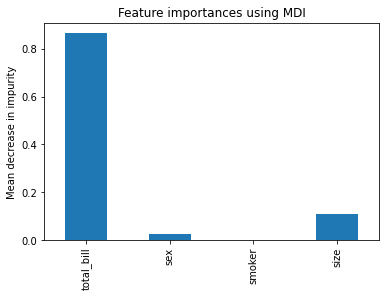

In [ ]:
with mlflow.start_run(run_name="figure_tips"):
    #
    # Generate feature importance plot thanks to feature_importances_ attribute of the RandomForestRegressor model
    feature_importances = pd.Series(fitted_rfr_model.feature_importances_, index=pd_df_X_train.columns)
    fig, ax = plt.subplots()
    feature_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    #
    # Log figure to mlflow
    mlflow.log_figure(fig, "feature_importance_rf.png")